Reading and Displaying the Image

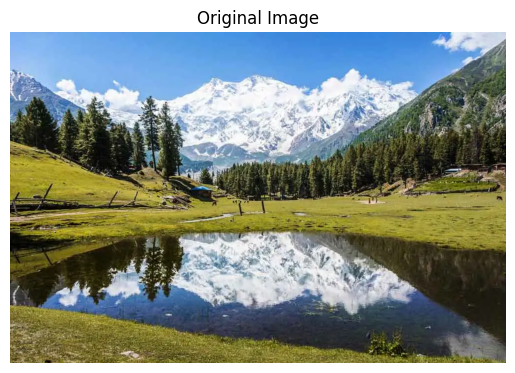

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.cluster import KMeans
from PIL import Image

img = imread('landscape.jpg')  # Ensure the image file is in the same directory
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()


Checking Image Dimensions

In [19]:
print(img.shape)  # Expected shape: (height, width, 3)

(667, 1000, 3)


Reshaping the Image

In [20]:
h, w, c = img.shape
print(f"Original dimensions: Height={h}, Width={w}, Channels={c}")
# Reshape the image data into a 2D array (pixels x channels)
# Each row is a pixel, each column is an RGB channel
X_pixels = img.reshape(-1, 3)  # Shape: (h*w, 3)
print(f"Reshaped data for K-means (X_pixels): Shape = {X_pixels.shape}")  # Expected shape: (height*width, 3)

Original dimensions: Height=667, Width=1000, Channels=3
Reshaped data for K-means (X_pixels): Shape = (667000, 3)


Normalizing the Pixel Values

In [21]:
if X_pixels.dtype == np.uint8:
    pixels = X_pixels / 255.0

1.Explanation of Preprocessing Steps

Reshaping the image into a 2D matrix is essential because K-means clustering requires input as a list of feature vectors. Each pixel's RGB values become a single feature vector.

Normalization ensures that the RGB values are on the same scale (typically [0, 1]), which helps the K-means algorithm converge more efficiently and prevents dominance of one channel due to higher magnitude.

Running KMeans with K = 4...
Running KMeans with K = 8...
Running KMeans with K = 16...
Running KMeans with K = 32...


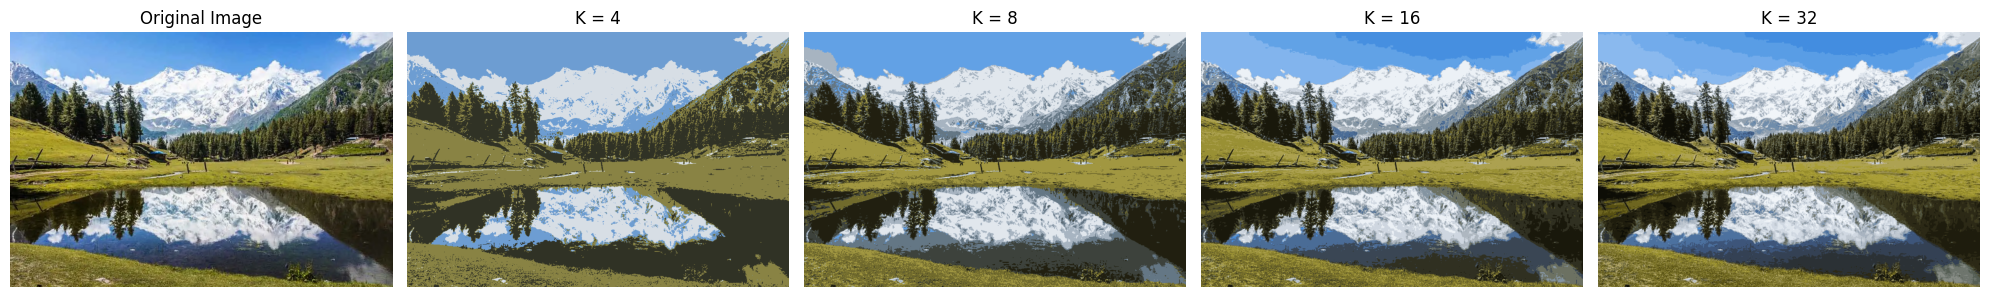

In [22]:
# Define K values
K_values = [4, 8, 16, 32]

# Create subplots
fig, axes = plt.subplots(1, len(K_values)+1, figsize=(20, 5))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Run K-means for each K
for i, K in enumerate(K_values):
    print(f'Running KMeans with K = {K}...')
    kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
    kmeans.fit(pixels)
    new_colors = kmeans.cluster_centers_[kmeans.labels_]
    segmented_img = new_colors.reshape(h, w, c)

    # Display segmented image
    axes[i+1].imshow(segmented_img)
    axes[i+1].set_title(f'K = {K}')
    axes[i+1].axis('off')

    # Convert image to uint8 before saving
    save_img = (segmented_img * 255).astype(np.uint8)
    Image.fromarray(save_img).save(f'segmented_k{K}.jpg')

plt.tight_layout()
plt.show()

Analysis of Segmentation Quality by K

K = 4:
Image is heavily quantized, with only four colors used across the whole image. Major regions like sky, water, and trees may appear with abrupt boundaries and color blocks. This is high compression but low fidelity.

K = 8:
Slightly better representation of distinct regions. Some finer features appear, and color transitions are smoother than in K=4.

K = 16:
Balanced trade-off — captures a decent amount of color variation. Different objects/regions (like tree vs mountain vs water) are now more accurately distinguishable. Good compression with visually reasonable quality.

K = 32:
High fidelity — the segmented image appears closer to the original. Fine color gradients and transitions are preserved, though compression is less aggressive.

bits/pixel 2.0
centroid_bits 384
Original Size: 15.27 MB
Compressed Size: 1.27 MB
Compression Ratio for K=4: 12.00

bits/pixel 3.0
centroid_bits 768
Original Size: 15.27 MB
Compressed Size: 1.91 MB
Compression Ratio for K=8: 8.00

bits/pixel 4.0
centroid_bits 1536
Original Size: 15.27 MB
Compressed Size: 2.55 MB
Compression Ratio for K=16: 6.00

bits/pixel 5.0
centroid_bits 3072
Original Size: 15.27 MB
Compressed Size: 3.18 MB
Compression Ratio for K=32: 4.80



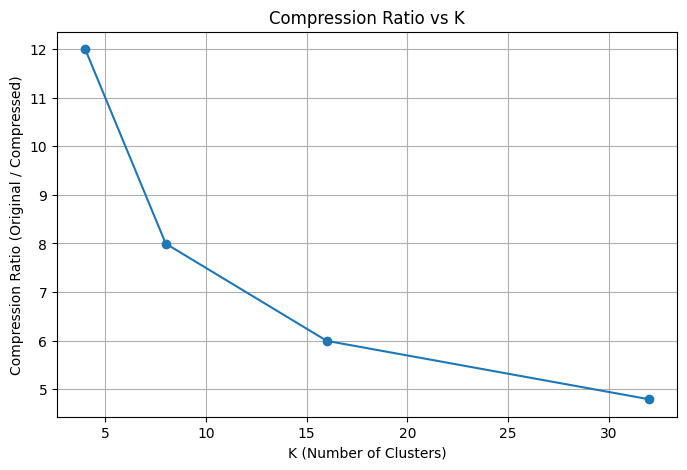

In [23]:
N = h * w  # Total number of pixels
compression_ratios = []

for K in K_values:
    bits_per_pixel = np.log2(K)
    centroid_bits = K * 3 * 32  # Each centroid has 3 float32 values
    compressed_size = N * bits_per_pixel + centroid_bits
    original_size = N * 24  # 24 bits per pixel for RGB

    compression_ratio = original_size / compressed_size
    compression_ratios.append(compression_ratio)
    
    print("bits/pixel", bits_per_pixel)
    print("centroid_bits", centroid_bits)
    print(f'Original Size: {original_size / (1024**2):.2f} MB')
    print(f'Compressed Size: {compressed_size / (1024**2):.2f} MB')     
    print(f'Compression Ratio for K={K}: {compression_ratio:.2f}')
    print("")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(K_values, compression_ratios, marker='o', linestyle='-')
plt.title('Compression Ratio vs K')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Compression Ratio (Original / Compressed)')
plt.grid(True)
plt.show()

| K  | Bits/Pixel | Centroid Storage (bits) | Original Size(MB)| Compressed Size(MB)| Compression Ratio |
| -- | ---------- | ----------------------- | ------------ | ---------------| ----------------- |
| 4  | 2.0        | 384                     |    15.27          |        1.27        |        \~12.00      |
| 8  | 3.0        | 768                     |    15.27          |        1.91        |         \~8.00     |
| 16 | 4.0        | 1536                    |    15.27          |        2.55        |        \~6.00     |
| 32 | 5.0        | 302                     |    15.27          |        3.18        |        \~4.80      |


#### Original Image Size:

Each pixel uses 24 bits (3 bytes) for RGB.

Total size: 𝑁×24,where N=h×w.

#### Compressed Image Size using K-means:

Each pixel: needs log₂(K) bits to represent cluster index.

Plus: storage of K RGB centroids, each with 3 floats (assume 32 bits per float).

So, total compressed size:

Compressed Size = N⋅log_2(K)+K⋅3⋅32


Compression Ratio= 
N⋅24/(N⋅log 
2
​
 (K)+K⋅96)

​


 ### Discussion
 
#### Tradeoff Between Compression Ratio and Image Quality:

   > Higher compression (low K) → less memory but poorer segmentation quality (blotchy image, loss of details).

   > Lower compression (high K) → better visual fidelity, but more storage needed.

Sweet Spot: For many images, K=16 often offers a good balance — perceptually reasonable quality with decent compression.

Centroid Storage Overhead becomes less significant as image size increases, so real-world compression ratios can be even better on larger images.